In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

/home/teguh/.local/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/home/teguh/.local/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/teguh/.local/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/teguh/.local/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/home/teguh/.local/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary

### Plot Gaussian

In [2]:
from matplotlib.patches import Ellipse    
        
def plot_gaussian(mus, sigmas, ax, weights = None):
    K = len(mus)
    if weights is None:
        weights = np.ones(K)/K
    
    for k in range(len(mus)):
        sigma = sigmas[k]
        val,vec = np.linalg.eig(sigma)
        angle = np.arctan2(vec[0,1], vec[0,0])
        ells = Ellipse(xy=mus[k],
                width=4.*np.sqrt(val[0]), height=4.*np.sqrt(val[1]),
                angle=np.rad2deg(angle))
        #ells.set_clip_box(a.bbox)
        ells.set_alpha(weights[k])
        ax.add_artist(ells)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    return

### Generate Data

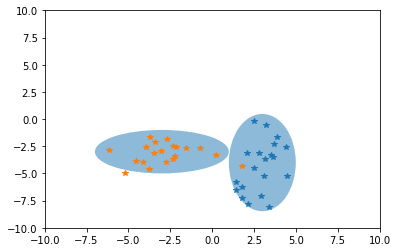

In [3]:
D = 2
mu1 = np.array([3., -4.])
sigma1 = np.diag([1., 5.])

mu2 = np.array([-3., -3.])
sigma2 = np.diag([4., 1.])

N = 40

sample1 = np.random.multivariate_normal(mu1, cov = sigma1, size = N/2)
sample2 = np.random.multivariate_normal(mu2, cov = sigma2, size = N/2)
samples = np.vstack([sample1, sample2])
fig,ax = plt.subplots()
plot_gaussian([mu1,mu2],[sigma1,sigma2],ax)
plt.plot(sample1[:,0],sample1[:,1],'*')
plt.plot(sample2[:,0],sample2[:,1],'*')


### Gaussian Mixture Model

In [4]:
import time

In [5]:
K = 3
pis = np.ones(K)/K
mus = np.random.rand(K,D)
sigmas = np.array([np.eye(D) for i in range(K)])
zs = np.zeros((N,K))

In [6]:
from IPython.display import clear_output
for j in range(20):    
    ###  E-Step
    for i in range(N):
        for k in range(K):
            zs[i,k] = pis[k]*mvn.pdf(samples[i,:],mus[k], sigmas[k])

        zs[i,:] = zs[i,:]/np.sum(zs[i,:])
    Ns = np.sum(zs,axis=0)

    ### M-Step
    for k in range(K):
        mus[k,:] = np.dot(zs[:,k].T, samples)/Ns[k]
        sigma_k = np.zeros((D,D))
        for i in range(N):
            sigma_k += zs[i,k]*np.outer(samples[i,:]-mus[k,:], samples[i,:].T-mus[k,:].T)
        sigma_k /= Ns[k]
        sigmas[k,:] = sigma_k
        pis[k] = Ns[k]/N 
    print mus
    
    plot_gaussian(mus,sigmas,pis)
    plt.plot(sample1[:,0],sample1[:,1],'r*',zorder = 0)
    plt.plot(sample2[:,0],sample2[:,1],'y*',zorder = 0)
    plt.show()
    #raw_input()
    clear_output(wait=True)
    
    time.sleep(0.1)


[[ 1.8107879  -4.03195837]
 [-0.96843402 -3.01080916]
 [-3.013334   -2.77695737]]


AttributeError: 'numpy.ndarray' object has no attribute 'add_artist'

### Bayesian Gaussian Mixture 

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

In [ ]:
bgmm = BayesianGaussianMixture(n_components=4, n_init=5)
bgmm.fit(samples)
plot_gaussian(bgmm.means_, bgmm.covariances_, bgmm.weights_)
plt.plot(sample1[:,0],sample1[:,1],'r*',zorder = 0)
plt.plot(sample2[:,0],sample2[:,1],'y*',zorder = 0)

### Implement different techniques: MCMC sampling, Laplace Approximations, and Gaussian Variational Approximations 

### Generate Data

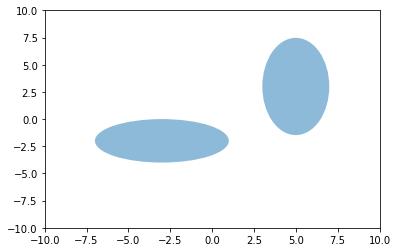

In [430]:
import numpy as np
import matplotlib.pyplot as plt
D = 2
K = 4
mu1 = np.array([5., 3.])
sigma1 = np.diag([1., 5.])

mu2 = np.array([-3., -2.])
sigma2 = np.diag([4., 1.])

N = 300

sample1 = np.random.multivariate_normal(mu1, cov = sigma1, size = 2*N/4)
sample2 = np.random.multivariate_normal(mu2, cov = sigma2, size = 2*N/4)
samples = np.vstack([sample1, sample2])
fig,ax = plt.subplots()
plot_gaussian([mu1,mu2],[sigma1,sigma2],ax)
#plt.hist(sample1)
#plt.hist(sample2)


In [431]:
from scipy.stats import multivariate_normal as mvn
from scipy.stats import dirichlet, invwishart, wishart
from tensorflow_probability import distributions as tfd


In [432]:
import tensorflow as tf

In [433]:
sess = tf.InteractiveSession()


In [444]:
def log_posterior(data, pis, mus, sigmas):
    val = tf.zeros(1)

    for i in range(data.shape[0]):
        val += tf.log(tf.reduce_sum([pis[k]*tfd.MultivariateNormalTriL(mus[k], 
                                        sigmas[k]).prob(data[i]) for k in range(pis.shape[0])]))
    
    return val

In [445]:
pi1 = tf.Variable((1.))
pi2 = tf.Variable((1.))
pis = tf.stack([tf.exp(pi1)/(tf.exp(pi1)+tf.exp(pi2)), tf.exp(pi2)/(tf.exp(pi1)+tf.exp(pi2))])
mus = tf.Variable(tf.random_uniform((2,2)),dtype=tf.float32)
a = np.ones([D,D],dtype=np.float32)
L11 = tf.Variable(2.)
L12 = tf.Variable(2.)
L21 = tf.Variable(2.)
L22 = tf.Variable(2.)

L1 = tf.diag([L11,L12])
L2 = tf.diag([L21,L22])
sigmas = tf.stack([L1,L2])

data = tf.placeholder(tf.float32, shape=[50,2])

In [446]:
post = log_posterior(data,pis,mus, sigmas)

In [447]:
optimizer = tf.train.AdamOptimizer(0.01)

train = optimizer.minimize(-post,var_list=[mus,L11,L12,L21,L22])

In [448]:
sess.run(tf.global_variables_initializer())

In [449]:
for i in range(1000):
    np.random.shuffle(samples)
    _,val,mus_val,sigmas_val,pis_val = sess.run([train,post,mus,sigmas,pis], feed_dict={data:samples[0:50]})
    print val,sigmas_val

[-343.25146] [[[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]]
[-339.45566] [[[2.01 0.  ]
  [0.   2.01]]

 [[2.01 0.  ]
  [0.   2.01]]]
[-315.9889] [[[2.0200016 0.       ]
  [0.        2.0199535]]

 [[2.0199897 0.       ]
  [0.        2.0199697]]]
[-312.21603] [[[2.0299306 0.       ]
  [0.        2.0292783]]

 [[2.0299895 0.       ]
  [0.        2.0292838]]]
[-328.47488] [[[2.0398529 0.       ]
  [0.        2.0386105]]

 [[2.039769  0.       ]
  [0.        2.0383859]]]
[-316.79797] [[[2.049822  0.       ]
  [0.        2.0479429]]

 [[2.0496016 0.       ]
  [0.        2.047499 ]]]
[-325.6886] [[[2.059649  0.       ]
  [0.        2.0574677]]

 [[2.0593266 0.       ]
  [0.        2.0567913]]]
[-333.60718] [[[2.0694547 0.       ]
  [0.        2.0670884]]

 [[2.069059  0.       ]
  [0.        2.0662353]]]
[-326.36798] [[[2.0793147 0.       ]
  [0.        2.0767677]]

 [[2.0788271 0.       ]
  [0.        2.0757847]]]
[-311.49768] [[[2.089066  0.       ]
  [0.        2.0865245]]

 [[2.0886488 0.   

[-272.33795] [[[2.6930943 0.       ]
  [0.        2.625008 ]]

 [[2.6572988 0.       ]
  [0.        2.1684735]]]
[-274.8626] [[[2.6972306 0.       ]
  [0.        2.6277437]]

 [[2.6608772 0.       ]
  [0.        2.1614106]]]
[-269.84814] [[[2.7013354 0.       ]
  [0.        2.6304142]]

 [[2.6644435 0.       ]
  [0.        2.1545446]]]
[-274.27075] [[[2.7053418 0.       ]
  [0.        2.6330264]]

 [[2.6680176 0.       ]
  [0.        2.1473808]]]
[-263.27103] [[[2.70932  0.      ]
  [0.       2.635884]]

 [[2.671491 0.      ]
  [0.       2.13986 ]]]
[-275.69586] [[[2.7130647 0.       ]
  [0.        2.6383903]]

 [[2.6749263 0.       ]
  [0.        2.1323664]]]
[-260.90723] [[[2.7167723 0.       ]
  [0.        2.6409047]]

 [[2.678272  0.       ]
  [0.        2.1253536]]]
[-276.56195] [[[2.7202675 0.       ]
  [0.        2.6435611]]

 [[2.6814404 0.       ]
  [0.        2.1179097]]]
[-276.49094] [[[2.7238035 0.       ]
  [0.        2.6462746]]

 [[2.6844623 0.       ]
  [0.        2.110

[-251.73375] [[[2.889741  0.       ]
  [0.        2.6826432]]

 [[2.7589242 0.       ]
  [0.        1.1415374]]]
[-240.92769] [[[2.890026  0.       ]
  [0.        2.6813476]]

 [[2.758201  0.       ]
  [0.        1.1315974]]]
[-252.259] [[[2.8904011 0.       ]
  [0.        2.6799402]]

 [[2.7572782 0.       ]
  [0.        1.120998 ]]]
[-245.971] [[[2.8907409 0.       ]
  [0.        2.6786997]]

 [[2.756354  0.       ]
  [0.        1.1121013]]]
[-249.6708] [[[2.8909435 0.       ]
  [0.        2.677357 ]]

 [[2.7554774 0.       ]
  [0.        1.1026812]]]
[-242.37349] [[[2.8910875 0.       ]
  [0.        2.675877 ]]

 [[2.7546704 0.       ]
  [0.        1.0947012]]]
[-231.83372] [[[2.891237  0.       ]
  [0.        2.6740768]]

 [[2.7537646 0.       ]
  [0.        1.0859175]]]
[-244.01315] [[[2.8912983 0.       ]
  [0.        2.672553 ]]

 [[2.7528255 0.       ]
  [0.        1.0753473]]]
[-256.00388] [[[2.8912654 0.       ]
  [0.        2.6711228]]

 [[2.751792  0.       ]
  [0.        1

[-226.1908] [[[2.770279   0.        ]
  [0.         2.4983897 ]]

 [[2.5587947  0.        ]
  [0.         0.91287494]]]
[-234.35411] [[[2.7678885 0.       ]
  [0.        2.4961386]]

 [[2.5554073 0.       ]
  [0.        0.9075155]]]
[-230.8933] [[[2.765437   0.        ]
  [0.         2.494188  ]]

 [[2.55221    0.        ]
  [0.         0.90103966]]]
[-235.42107] [[[2.7630086  0.        ]
  [0.         2.4922507 ]]

 [[2.5488274  0.        ]
  [0.         0.89542973]]]
[-231.28151] [[[2.7605493 0.       ]
  [0.        2.4905052]]

 [[2.5455296 0.       ]
  [0.        0.8907373]]]
[-239.8894] [[[2.758078  0.       ]
  [0.        2.4886384]]

 [[2.5424263 0.       ]
  [0.        0.8858614]]]
[-231.42307] [[[2.75566   0.       ]
  [0.        2.4868307]]

 [[2.539291  0.       ]
  [0.        0.882977 ]]]
[-238.95297] [[[2.7532725  0.        ]
  [0.         2.4851658 ]]

 [[2.5359554  0.        ]
  [0.         0.88254595]]]
[-228.51376] [[[2.7508197  0.        ]
  [0.         2.4835825 ]]



[-232.15616] [[[2.3934212 0.       ]
  [0.        2.2895079]]

 [[2.167457  0.       ]
  [0.        0.9608228]]]
[-219.19919] [[[2.3878453 0.       ]
  [0.        2.2902558]]

 [[2.1639636 0.       ]
  [0.        0.9610385]]]
[-216.56824] [[[2.3822494  0.        ]
  [0.         2.2902038 ]]

 [[2.1601846  0.        ]
  [0.         0.96199423]]]
[-225.08733] [[[2.3764975 0.       ]
  [0.        2.289175 ]]

 [[2.1562455 0.       ]
  [0.        0.9616438]]]
[-224.03792] [[[2.3707442 0.       ]
  [0.        2.2881367]]

 [[2.1521435 0.       ]
  [0.        0.9613953]]]
[-225.60179] [[[2.3648016 0.       ]
  [0.        2.286507 ]]

 [[2.1483963 0.       ]
  [0.        0.9606974]]]
[-218.3586] [[[2.3588731  0.        ]
  [0.         2.284458  ]]

 [[2.1446187  0.        ]
  [0.         0.96040195]]]
[-218.52898] [[[2.3531165 0.       ]
  [0.        2.28318  ]]

 [[2.1406043 0.       ]
  [0.        0.9598297]]]
[-218.72778] [[[2.3474343 0.       ]
  [0.        2.2817361]]

 [[2.136539  0.   

[-208.96251] [[[1.7345773 0.       ]
  [0.        2.2234216]]

 [[1.7837925 0.       ]
  [0.        0.9807831]]]
[-217.3399] [[[1.7263461 0.       ]
  [0.        2.2254927]]

 [[1.7811362 0.       ]
  [0.        0.9810624]]]
[-212.5028] [[[1.7181873  0.        ]
  [0.         2.227347  ]]

 [[1.778518   0.        ]
  [0.         0.98109823]]]
[-217.29462] [[[1.7100146 0.       ]
  [0.        2.2284248]]

 [[1.775803  0.       ]
  [0.        0.9807632]]]
[-213.53568] [[[1.7016034 0.       ]
  [0.        2.2305846]]

 [[1.7731005 0.       ]
  [0.        0.9800028]]]
[-223.0229] [[[1.6934884 0.       ]
  [0.        2.2323833]]

 [[1.770196  0.       ]
  [0.        0.9796914]]]
[-213.8766] [[[1.6853285  0.        ]
  [0.         2.2350314 ]]

 [[1.7670639  0.        ]
  [0.         0.98089063]]]
[-219.56407] [[[1.6773567  0.        ]
  [0.         2.2390816 ]]

 [[1.7637609  0.        ]
  [0.         0.98017097]]]
[-208.45296] [[[1.669394  0.       ]
  [0.        2.2437656]]

 [[1.7605989 

[-209.09264] [[[0.96608526 0.        ]
  [0.         2.2111576 ]]

 [[1.6376357  0.        ]
  [0.         0.94279367]]]
[-205.15103] [[[0.9619602  0.        ]
  [0.         2.2102494 ]]

 [[1.6375053  0.        ]
  [0.         0.93966305]]]
[-199.21718] [[[0.9577398  0.        ]
  [0.         2.2094846 ]]

 [[1.6377494  0.        ]
  [0.         0.93646234]]]
[-218.58177] [[[0.9527846  0.        ]
  [0.         2.208076  ]]

 [[1.6386616  0.        ]
  [0.         0.93291867]]]
[-210.43137] [[[0.94881403 0.        ]
  [0.         2.207557  ]]

 [[1.6393745  0.        ]
  [0.         0.93240356]]]
[-203.15117] [[[0.94543666 0.        ]
  [0.         2.2064745 ]]

 [[1.6403425  0.        ]
  [0.         0.93373007]]]
[-208.39145] [[[0.94146377 0.        ]
  [0.         2.206856  ]]

 [[1.6413859  0.        ]
  [0.         0.9330266 ]]]
[-203.3783] [[[0.93812096 0.        ]
  [0.         2.2073617 ]]

 [[1.6424433  0.        ]
  [0.         0.93305874]]]
[-211.36154] [[[0.9337205 0.     

[-202.48769] [[[0.92008007 0.        ]
  [0.         2.1399345 ]]

 [[1.6390063  0.        ]
  [0.         0.9188654 ]]]
[-210.74257] [[[0.9204229 0.       ]
  [0.        2.1377966]]

 [[1.6384492 0.       ]
  [0.        0.9176498]]]
[-211.94974] [[[0.92096967 0.        ]
  [0.         2.1364431 ]]

 [[1.638238   0.        ]
  [0.         0.91730773]]]
[-198.38873] [[[0.9217599 0.       ]
  [0.        2.1357424]]

 [[1.6382444 0.       ]
  [0.        0.917799 ]]]
[-198.9401] [[[0.92294765 0.        ]
  [0.         2.134835  ]]

 [[1.638343   0.        ]
  [0.         0.91605437]]]
[-203.7587] [[[0.9253288 0.       ]
  [0.        2.133897 ]]

 [[1.6371893 0.       ]
  [0.        0.9135803]]]
[-196.47214] [[[0.9266695 0.       ]
  [0.        2.132973 ]]

 [[1.6366215 0.       ]
  [0.        0.9118014]]]
[-203.01071] [[[0.9273798 0.       ]
  [0.        2.1323404]]

 [[1.6351082 0.       ]
  [0.        0.9095132]]]
[-204.87852] [[[0.9271452  0.        ]
  [0.         2.13213   ]]

 [[1.63

[-202.6488] [[[0.92407346 0.        ]
  [0.         2.1184545 ]]

 [[1.6679727  0.        ]
  [0.         0.9141196 ]]]
[-222.22955] [[[0.92231643 0.        ]
  [0.         2.1196792 ]]

 [[1.6678469  0.        ]
  [0.         0.9120306 ]]]
[-193.9274] [[[0.9215736 0.       ]
  [0.        2.1226773]]

 [[1.6676567 0.       ]
  [0.        0.9120374]]]
[-192.07506] [[[0.92008483 0.        ]
  [0.         2.1241374 ]]

 [[1.6681724  0.        ]
  [0.         0.91066504]]]
[-203.6034] [[[0.9189565  0.        ]
  [0.         2.125114  ]]

 [[1.6680965  0.        ]
  [0.         0.90724754]]]
[-198.24295] [[[0.91850275 0.        ]
  [0.         2.1263485 ]]

 [[1.6673764  0.        ]
  [0.         0.90406907]]]
[-203.41466] [[[0.9177154  0.        ]
  [0.         2.126768  ]]

 [[1.6671569  0.        ]
  [0.         0.90098315]]]
[-202.20602] [[[0.9172653  0.        ]
  [0.         2.1269464 ]]

 [[1.667686   0.        ]
  [0.         0.89720994]]]
[-205.30367] [[[0.9162987 0.       ]
  [0. 

[-193.00774] [[[0.9458887  0.        ]
  [0.         2.2099679 ]]

 [[1.6770612  0.        ]
  [0.         0.89884174]]]
[-206.86105] [[[0.9458913  0.        ]
  [0.         2.2075236 ]]

 [[1.6761439  0.        ]
  [0.         0.89537865]]]
[-204.08612] [[[0.94648767 0.        ]
  [0.         2.2055569 ]]

 [[1.6752527  0.        ]
  [0.         0.89185697]]]
[-212.53133] [[[0.9463122 0.       ]
  [0.        2.2035506]]

 [[1.6742166 0.       ]
  [0.        0.890155 ]]]
[-192.73152] [[[0.9461659 0.       ]
  [0.        2.2022042]]

 [[1.6732578 0.       ]
  [0.        0.8909862]]]
[-211.92848] [[[0.94556326 0.        ]
  [0.         2.2003038 ]]

 [[1.671641   0.        ]
  [0.         0.89095575]]]
[-201.86646] [[[0.9457821 0.       ]
  [0.        2.1977851]]

 [[1.670774  0.       ]
  [0.        0.8925895]]]
[-197.48053] [[[0.94488245 0.        ]
  [0.         2.1950607 ]]

 [[1.6701047  0.        ]
  [0.         0.8951331 ]]]
[-203.60487] [[[0.9440531 0.       ]
  [0.        2.1917

[-207.3398] [[[0.91551375 0.        ]
  [0.         2.1152833 ]]

 [[1.6870986  0.        ]
  [0.         0.9170885 ]]]
[-211.00696] [[[0.91592765 0.        ]
  [0.         2.114167  ]]

 [[1.6865954  0.        ]
  [0.         0.9185945 ]]]
[-209.70215] [[[0.91619956 0.        ]
  [0.         2.1154888 ]]

 [[1.6853498  0.        ]
  [0.         0.92024684]]]
[-207.42862] [[[0.91737187 0.        ]
  [0.         2.117457  ]]

 [[1.6844908  0.        ]
  [0.         0.9210807 ]]]
[-208.70462] [[[0.9182603  0.        ]
  [0.         2.1211894 ]]

 [[1.6823637  0.        ]
  [0.         0.92274064]]]
[-205.01683] [[[0.91754895 0.        ]
  [0.         2.1256862 ]]

 [[1.6804949  0.        ]
  [0.         0.9257158 ]]]
[-192.28824] [[[0.917333  0.       ]
  [0.        2.128343 ]]

 [[1.6786723 0.       ]
  [0.        0.9302258]]]
[-206.05524] [[[0.9158268 0.       ]
  [0.        2.1298127]]

 [[1.6768371 0.       ]
  [0.        0.9335743]]]
[-204.4716] [[[0.91350245 0.        ]
  [0.      

In [450]:
print mus.eval()

print pis.eval()

print sigmas.eval()

[[ 4.9579325  3.298444 ]
 [-3.2872772 -2.0012572]]
[0.5 0.5]
[[[0.8946103 0.       ]
  [0.        2.1313367]]

 [[1.6671004 0.       ]
  [0.        0.9540385]]]


In [451]:
print mu1,mu2
print sigma1,sigma2

[5. 3.] [-3. -2.]
[[1. 0.]
 [0. 5.]] [[4. 0.]
 [0. 1.]]


In [452]:
for sigma in sigmas.eval():
    print (tf.matmul(sigma,tf.transpose(sigma))).eval()

[[0.80032754 0.        ]
 [0.         4.542596  ]]
[[2.779224   0.        ]
 [0.         0.91018945]]


In [44]:
def log_gaussian_prior(mu_0 = tf.zeros(D), sigma_0 = tf.eye(D)):
    func = lambda mu: tfd.MultivariateNormalFullCovariance(loc=mu_0, covariance_matrix = sigma_0).log_prob(mu)
    return func
    
def log_dirichlet_prior(alphas = tf.ones(K)/K):
    def func( pis):
        return tfd.Dirichlet(alphas).log_prob(pis)
    return func
    
def log_wishart_prior(df = D, scale = tf.eye(D)):
    func = lambda sigma: tfd.Wishart(df,scale).log_prob(sigma)
    return func

In [45]:
def log_joint_prior():
    log_prior_mu  = log_gaussian_prior()
    log_prior_pis = log_dirichlet_prior()
    log_prior_sigma = log_wishart_prior()
    func = lambda mus, sigmas, pis: np.sum([log_prior_mu(mu) for mu in mus]) + log_prior_pis(pis) + np.sum([log_prior_sigma(sigma) for sigma in sigmas])
    return func

def log_likelihood(x):
    func = lambda mus, sigmas, pis: tf.log(tf.reduce_sum([pis[k]*tfd.MultivariateNormalFullCovariance(mus[k], sigmas[k]).prob(x) for k in range(len(pis))]))
    return func
    
def log_posterior(data):
    log_prior = log_joint_prior()
    
    def func(theta):
        mus, sigmas, pis = theta[0], theta[1], theta[2]
        val = log_prior(mus, sigmas, pis)
        print val.dtype
        for i in range(data.shape[0]):
            print 'yes'
            log_likelihood_datapoint = log_likelihood(data[i])
            b = log_likelihood_datapoint(mus, sigmas, pis)
            b = tf.cast(b,tf.float32)
            val = val + b#log_likelihood_datapoint(mus, sigmas, pis)
        
        return val
    
    return func

In [84]:
tf.convert_to_tensor(theta0)

ValueError: could not broadcast input array from shape (4,2) into shape (4)

In [47]:
sigmas_true = np.array([sigma1, sigma2])
mus_true = np.array([mu1, mu2])
pis_true = np.array([0.25, 0.75])
data = tf.placeholder(tf.float64, shape=[10,2])
log_posterior_data = log_posterior(data)

In [48]:
post = log_posterior_data(theta0)

<dtype: 'float32'>
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [49]:
data1 = samples[0:10]

In [78]:
np.random.shuffle(samples)
data1 = samples[0:10]

post.eval(feed_dict={data:data1})

-671.1405

In [83]:
tf.gradients(post, mu1)

[None]

### Plotting the cross-section of the posteriors

In [16]:
def random_move(theta, lamda = 0.05):
    mus, sigmas, pis = np.copy(theta[0]), np.copy(theta[1]), np.copy(theta[2])
    for k in range(len(mus)):
        delta_mu = lamda*mvn.rvs(mean=np.zeros(D))
        mus[k] += delta_mu
        
        sigmas[k] = invwishart.rvs(df = 600., scale = 600*sigmas[k])
        #sigmas[k] += delta_sigma
        #sigmas[k]  = np.exp(np.log(sigmas[k]) + 2*lamda*np.random.normal())
        
        delta_pis = lamda*dirichlet.rvs(np.ones(K)/K).flatten()
        pis += delta_pis
    
    pis = pis / np.sum(pis)
    
    return [mus, sigmas, pis]

### Do MCMC on the unnormalized posterior

In [450]:
def MH_sampling(func,theta0, n = 1000, lamda= 0.05):
    samples = [theta0]
    cur_theta = theta0
    accept_num = 0
    for i in range(n):
        cur_func_value = func(cur_theta)
        #Proposal distribution
        new_theta = random_move(cur_theta,lamda)

        new_func_value = func(new_theta)

        #decide whether to accept or reject
        accept_threshold = np.exp(new_func_value-cur_func_value)

        random_num = np.random.rand()
        if random_num < accept_threshold: #equivalent to the above
            samples.append(new_theta)
            cur_theta = new_theta
            accept_num += 1
            print 'accept'
        else:
            samples.append(cur_theta)
            
        if i%10 == 0: print i
    
    return (samples), 1.0*accept_num/n

In [452]:
from IPython.display import clear_output

In [453]:
posterior_samples, success_rate = MH_sampling(log_posterior_data, theta0, n = 4000, lamda = 0.1)
clear_output()
print success_rate

0.02925


In [454]:
samples_mus = []
samples_sigmas = []
samples_pis = []

for sample in posterior_samples:
    samples_mus.append(sample[0])
    samples_sigmas.append(sample[1])
    samples_pis.append(sample[2])

In [455]:
print np.mean(np.array(samples_mus[2000:]), axis=0)

print np.mean(np.array(samples_sigmas[2000:]), axis=0)

print np.mean(np.array(samples_pis[2000:]), axis=0)

print mu1, mu2

print sigma1, sigma2

[[ 9.4798732   9.71124622]
 [-9.86184596 -9.50564643]
 [ 4.51188032  6.57828327]
 [-6.51560007 -3.21434003]]
[[[ 0.29761399  0.1037639 ]
  [ 0.1037639   1.44513816]]

 [[ 1.13379088  0.52366492]
  [ 0.52366492  2.01064631]]

 [[ 0.63994865  0.95664691]
  [ 0.95664691  4.69362593]]

 [[47.27229626 15.42335304]
  [15.42335304  6.3373299 ]]]
[0.06180786 0.05401991 0.13955565 0.74461658]
[5. 3.] [-3. -2.]
[[1. 0.]
 [0. 5.]] [[4. 0.]
 [0. 1.]]


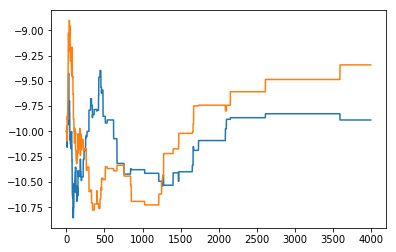

In [456]:
plt.plot(np.array(samples_mus)[:,1])

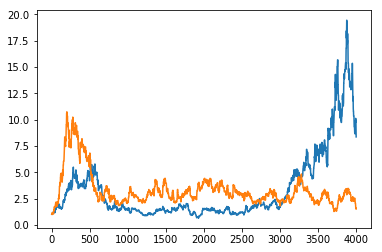

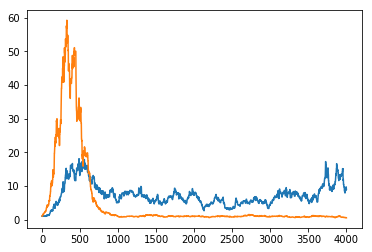

In [396]:
plt.figure()
plt.plot(np.array(samples_sigmas)[:,:,0,0])
plt.figure()
plt.plot(np.array(samples_sigmas)[:,:,1,1])

In [397]:
posterior_samples = posterior_samples[2000:]

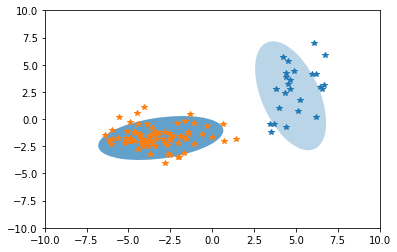

In [433]:
fig, ax = plt.subplots()
plt.plot(sample1[:,0],sample1[:,1],'*')
plt.plot(sample2[:,0],sample2[:,1],'*')
for i in range(1):
    index = np.random.randint(len(posterior_samples))
    sample = posterior_samples[index]
    mus, sigmas, pis = sample[0], sample[1], sample[2]
    plot_gaussian(mus,sigmas,ax,pis)
    
plt.show()

In [382]:
samples

array([[ 5.25376301e+00,  7.41959325e+00],
       [ 5.43632133e+00,  1.78844386e+00],
       [ 7.21531225e+00,  3.87524463e+00],
       [ 5.57769982e+00,  7.37318911e-01],
       [ 4.70028621e+00,  9.35727964e-01],
       [ 4.39008600e+00,  4.69068283e+00],
       [ 6.98331713e+00, -7.76986072e-01],
       [ 5.30648041e+00,  4.01401220e+00],
       [ 3.90801794e+00,  4.23397214e+00],
       [ 4.08152317e+00,  3.91564312e+00],
       [ 5.68001541e+00,  4.47426930e+00],
       [ 4.38769674e+00,  5.13474419e+00],
       [ 5.58540342e+00,  2.52211282e+00],
       [ 5.48652080e+00,  5.41210283e+00],
       [ 6.32155880e+00,  7.71076940e+00],
       [ 6.26227205e+00,  2.20632650e+00],
       [ 5.26530499e+00,  1.88581915e+00],
       [ 4.05551137e+00,  4.11604455e+00],
       [ 4.26654055e+00,  3.68700494e+00],
       [ 4.44987256e+00,  2.83748984e+00],
       [ 4.68845182e+00,  2.19415601e+00],
       [ 5.52601439e+00, -2.17683160e-01],
       [ 3.66179426e+00,  1.42540319e+00],
       [ 5.